In [1]:
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import os

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Optik
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# Config vom Kollegen
N_CLUSTERS = 3
SEGMENT_FEATURES = [
    "duration",
    "credit_amount",
    "age",
    "installment_rate",
    "residence_since",
    "existing_credits",
    "people_liable"
]

print("✅ Zelle 1: Setup fertig.")

✅ Zelle 1: Setup fertig.


/Users/renekarmrodt/vscode/jupyter/virtual_environment/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Prüfen, wo die Datei liegt
csv_file = 'german_numeric.csv'
if not os.path.exists(csv_file):
    csv_file = 'data/german_numeric.csv' # Fallback

print(f"📥 Lade Daten: {csv_file}")
X_raw = pd.read_csv(csv_file)

# Nur die gewünschten Spalten nutzen
X_seg = X_raw[SEGMENT_FEATURES].copy()

# 1. SCALING (Wichtig!)
print("📊 Skaliere Daten...")
scaler = StandardScaler()
X_seg_scaled = scaler.fit_transform(X_seg)  # <-- HIER wird die Variable definiert!

# 2. PCA (Dimensionen reduzieren für Plot & Cluster)
print("🔬 Führe PCA durch...")
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_seg_scaled)

print("✅ Zelle 2: Daten vorbereitet & skaliert.")

📥 Lade Daten: data/german_numeric.csv
📊 Skaliere Daten...
🔬 Führe PCA durch...
✅ Zelle 2: Daten vorbereitet & skaliert.


🤖 K-Means Clustering (k=3)...


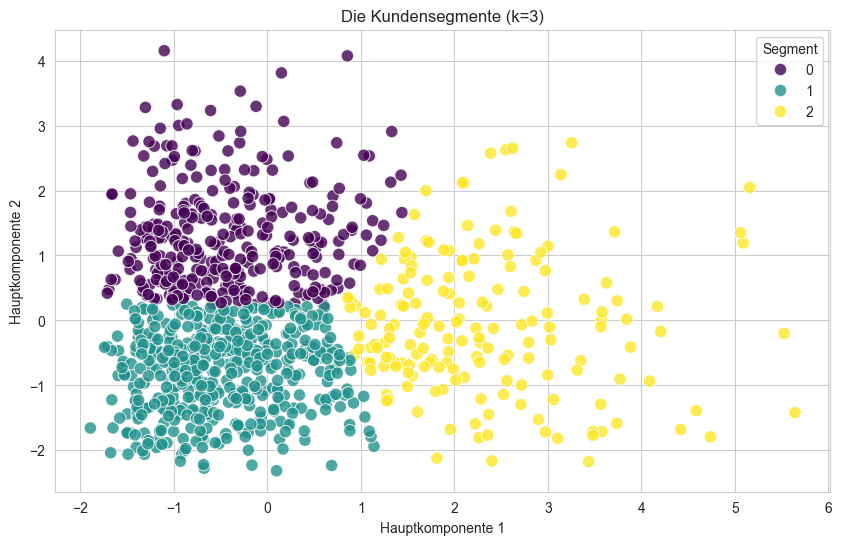

✅ Zelle 3: Modell trainiert.


In [3]:
# 1. CLUSTERING
print(f"🤖 K-Means Clustering (k={N_CLUSTERS})...")
kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=42, n_init=10)
# WICHTIG: Dein Kollege clustert auf den PCA-Daten!
clusters = kmeans.fit_predict(X_pca)

# Ergebnisse speichern für Plot
plot_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
plot_df['Cluster'] = clusters

# 2. VISUALISIERUNG (Cluster Map)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=plot_df, x='PC1', y='PC2', hue='Cluster', 
                palette='viridis', s=80, alpha=0.8, edgecolor='w')
plt.title(f'Die Kundensegmente (k={N_CLUSTERS})')
plt.xlabel('Hauptkomponente 1')
plt.ylabel('Hauptkomponente 2')
plt.legend(title='Segment')
plt.show()

print("✅ Zelle 3: Modell trainiert.")

In [7]:
# --- ZELLE 5: SHAP BERECHNUNG & FIX ---
print("🧠 Berechne SHAP-Werte (mit Pickle-Fix)...")

def cluster_proba_wrapper(data_scaled):
    data_pca = pca.transform(data_scaled)
    cluster_ids = kmeans.predict(data_pca)
    return np.eye(N_CLUSTERS)[cluster_ids]

# FIX: Wir stellen sicher, dass background_data ein REINES Numpy Array ist
# shap.sample gibt manchmal ein pandas DataFrame oder SHAP-Objekt zurück
background_data_raw = shap.sample(X_seg_scaled, 50)

if isinstance(background_data_raw, pd.DataFrame):
    background_data = background_data_raw.values
else:
    background_data = np.array(background_data_raw)

print(f"Hintergrund-Daten Typ: {type(background_data)}") # Sollte numpy.ndarray sein

# Explainer erstellen
explainer = shap.KernelExplainer(cluster_proba_wrapper, background_data)

# Berechnung
shap_values_raw = explainer.shap_values(X_seg_scaled[:100], nsamples=100)

# Format Fix (Liste vs Array)
shap_values_global = []
if isinstance(shap_values_raw, list):
    shap_values_global = shap_values_raw
elif isinstance(shap_values_raw, np.ndarray):
    if len(shap_values_raw.shape) == 3:
        shap_values_global = [shap_values_raw[:, :, i] for i in range(N_CLUSTERS)]
    else:
        shap_values_global = shap_values_raw

print("✅ SHAP berechnet.")



🧠 Berechne SHAP-Werte (mit Pickle-Fix)...
Hintergrund-Daten Typ: <class 'numpy.ndarray'>


100%|██████████| 100/100 [00:00<00:00, 287.09it/s]

✅ SHAP berechnet.


In [8]:
# --- ZELLE 6: EXPORT (Cluster Brain) - KORRIGIERT ---
print("💾 Speichere 'cluster_brain.pkl'...")

# WICHTIG: Wir speichern den Explainer NICHT (vermeidet Fehler).
# Wir speichern nur die Daten, damit das Dashboard schnell ist.

cluster_brain = {
    "model": kmeans,
    "scaler": scaler,          # KORRIGIERT: Hieß vorher scaler_seg
    "pca": pca,
    "pca_data": plot_df,       # KORRIGIERT: Hieß vorher X_seg_result
    "raw_features": SEGMENT_FEATURES,  
    "shap_values_global": shap_values_global, 
    "background_data": background_data 
}

joblib.dump(cluster_brain, 'cluster_brain.pkl')

print("🎉 Fertig! 'cluster_brain.pkl' wurde erfolgreich gespeichert!")

💾 Speichere 'cluster_brain.pkl'...
🎉 Fertig! 'cluster_brain.pkl' wurde erfolgreich gespeichert!
